In [1]:
from astropy import units as u
import numpy as np
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors
from scipy.stats import gaussian_kde

## Querying GAIA dr3 data
### TOP and SORT

In [15]:
query = f"""SELECT TOP 5000
gaia.source_id, gaia.ra,gaia.dec, gaia.parallax, gaia.parallax_error, gaia.distance_gspphot, 1000/gaia.parallax AS distance_parallax
FROM gaiadr3.gaia_source AS gaia
WHERE 
gaia.distance_gspphot < 500
AND gaia.parallax_over_error > 3.0
AND gaia.ruwe < 1.2
"""
job     = Gaia.launch_job_async(query)
results = job.get_results()
print(f'Table size (rows): {len(results)}')
results

INFO: Query finished. [astroquery.utils.tap.core]
Table size (rows): 5000


source_id,ra,dec,parallax,parallax_error,distance_gspphot,distance_parallax
,deg,deg,mas,mas,pc,
int64,float64,float64,float64,float32,float32,float64
5853498713190525696,217.39232147200883,-62.67607511676666,768.0665391873573,0.049872905,1.3011,1.3019705311704333
4472832130942575872,269.44850252543836,4.739420051112412,546.975939730948,0.040116355,1.8275,1.828233981355542
762815470562110464,165.83095967577933,35.948653032660104,392.75294543876464,0.03206665,2.5453,2.5461298549469777
4075141768785646848,282.4587890175222,-23.83709744872712,336.0266016683708,0.031666122,2.9762,2.9759548649868903
6553614253923452800,346.5039166796005,-35.8471642082214,304.1353692001036,0.01999573,3.2877,3.2880095551861235
3796072592206250624,176.93768799004127,0.7991199702364985,296.3053079139394,0.030185517,3.3731,3.374897355164646
1872046574983497216,316.753662752556,38.75607277205679,286.0053518616485,0.028940246,3.4947,3.4964380683468383
2154880616774131840,280.6830708352289,59.638357907754816,283.8401180184389,0.021992655,3.522,3.5231101472943926


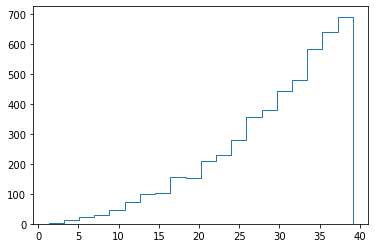

In [16]:
plt.hist(results["distance_gspphot"],histtype="step",bins=20);

### Order the results
Server sorts the results using the ORDER before applying TOP

In [17]:
query = f"""SELECT TOP 5000
gaia.source_id, gaia.ra,gaia.dec, gaia.parallax, gaia.parallax_error, gaia.distance_gspphot, 1000/ABS(gaia.parallax) AS distance_parallax
FROM gaiadr3.gaia_source AS gaia
WHERE 
gaia.distance_gspphot < 500
AND gaia.parallax_over_error > 3.0
AND gaia.ruwe < 1.2
ORDER BY gaia.distance_gspphot
"""
job     = Gaia.launch_job_async(query)
results = job.get_results()
print(f'Table size (rows): {len(results)}')
results

INFO: Query finished. [astroquery.utils.tap.core]
Table size (rows): 5000


source_id,ra,dec,parallax,parallax_error,distance_gspphot,distance_parallax
,deg,deg,mas,mas,pc,
int64,float64,float64,float64,float32,float32,float64
5853498713190525696,217.39232147200883,-62.67607511676666,768.0665391873573,0.049872905,1.3011,1.3019705311704333
4472832130942575872,269.44850252543836,4.739420051112412,546.975939730948,0.040116355,1.8275,1.828233981355542
762815470562110464,165.83095967577933,35.948653032660104,392.75294543876464,0.03206665,2.5453,2.5461298549469777
4075141768785646848,282.4587890175222,-23.83709744872712,336.0266016683708,0.031666122,2.9762,2.9759548649868903
6553614253923452800,346.5039166796005,-35.8471642082214,304.1353692001036,0.01999573,3.2877,3.2880095551861235
3796072592206250624,176.93768799004127,0.7991199702364985,296.3053079139394,0.030185517,3.3731,3.374897355164646
1872046574983497216,316.753662752556,38.75607277205679,286.0053518616485,0.028940246,3.4947,3.4964380683468383
2154880616774131840,280.6830708352289,59.638357907754816,283.8401180184389,0.021992655,3.522,3.5231101472943926


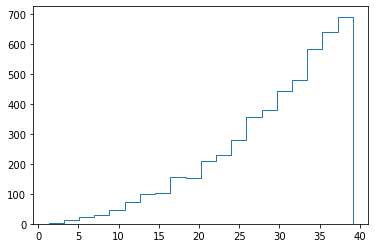

In [18]:
plt.hist(results["distance_gspphot"],histtype="step",bins=20);

### Randomize 

In [19]:
query = f"""SELECT 
gaia.source_id, gaia.ra,gaia.dec, gaia.parallax, gaia.parallax_error, gaia.distance_gspphot, 1000/ABS(gaia.parallax) AS distance_parallax
FROM gaiadr3.gaia_source AS gaia
WHERE 
gaia.distance_gspphot < 500
AND gaia.parallax_over_error > 3.0
AND gaia.ruwe < 1.2
AND gaia.random_index BETWEEN 0 AND 1000000
"""
job     = Gaia.launch_job_async(query)
results = job.get_results()
print(f'Table size (rows): {len(results)}')
results

INFO: Query finished. [astroquery.utils.tap.core]
Table size (rows): 8546


source_id,ra,dec,parallax,parallax_error,distance_gspphot,distance_parallax
,deg,deg,mas,mas,pc,
int64,float64,float64,float64,float32,float32,float64
2263228824739543936,296.5473251946255,70.70636720253104,4.322729106821513,0.13621487,231.2534,231.33533822925497
2268618252781773952,281.38391936240464,75.76260737261485,4.588680051299649,0.14708216,229.0641,217.9275932992475
2268674366530748288,280.3965798855927,76.44813993542458,8.36180461448321,0.011393991,119.4641,119.59140952276408
2267580111943810688,284.16272733672963,72.5984559063816,4.967150164161822,0.060245913,203.351,201.32268342017082
2269859674426592512,315.94533746121925,67.11376328650022,2.8293450328060277,0.061102953,340.1551,353.43868930974503
2270707878928364416,317.7012428349917,69.42693709479842,2.075482184382304,0.033499457,477.5908,481.8157474561101
2270763954021187840,315.80305294244897,69.74764751428287,3.090107378778484,0.025871946,320.5131,323.61334977145646
2270805765525072896,317.9780455277591,69.64797965771959,2.755272294023435,0.11913026,353.7862,362.9405348317615


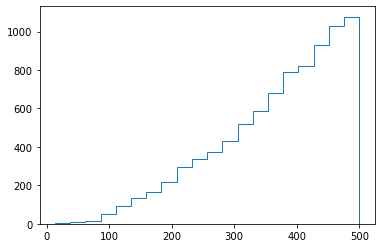

In [20]:
plt.hist(results["distance_gspphot"],histtype="step",bins=20);

#### Randomize and TOP

In [8]:
query = f"""SELECT TOP 5000
gaia.source_id, gaia.ra,gaia.dec, gaia.parallax, gaia.parallax_error, gaia.distance_gspphot, 1000/ABS(gaia.parallax) AS distance_parallax
FROM gaiadr3.gaia_source AS gaia
WHERE 
gaia.distance_gspphot < 500
AND gaia.parallax_over_error > 3.0
AND gaia.ruwe < 1.4
AND gaia.random_index BETWEEN 0 AND 10000
"""
job     = Gaia.launch_job_async(query)
results = job.get_results()
print(f'Table size (rows): {len(results)}')
results

INFO: Query finished. [astroquery.utils.tap.core]
Table size (rows): 5000


source_id,ra,dec,parallax,parallax_error,distance_gspphot,distance_parallax
,deg,deg,mas,mas,pc,
int64,float64,float64,float64,float32,float32,float64
2263228824739543936,296.5473251946255,70.70636720253104,4.322729106821513,0.13621487,231.2534,231.33533822925497
2268618252781773952,281.38391936240464,75.76260737261485,4.588680051299649,0.14708216,229.0641,217.9275932992475
2268674366530748288,280.3965798855927,76.44813993542458,8.36180461448321,0.011393991,119.4641,119.59140952276408
2267580111943810688,284.16272733672963,72.5984559063816,4.967150164161822,0.060245913,203.351,201.32268342017082
2269859674426592512,315.94533746121925,67.11376328650022,2.8293450328060277,0.061102953,340.1551,353.43868930974503
2270707878928364416,317.7012428349917,69.42693709479842,2.075482184382304,0.033499457,477.5908,481.8157474561101
2270763954021187840,315.80305294244897,69.74764751428287,3.090107378778484,0.025871946,320.5131,323.61334977145646
2270805765525072896,317.9780455277591,69.64797965771959,2.755272294023435,0.11913026,353.7862,362.9405348317615


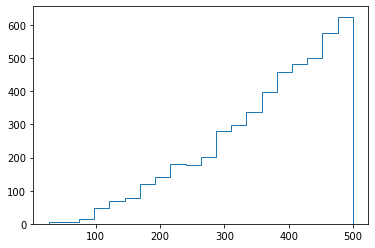

In [9]:
plt.hist(results["distance_gspphot"],histtype="step",bins=20);

### HR diagram

In [10]:
query = f"""SELECT TOP 50000
gaia.source_id, gaia.ra,gaia.dec, gaia.parallax, gaia.parallax_error, gaia.distance_gspphot, 1000/gaia.parallax AS distance_parallax, gaia.bp_rp, gaia.phot_g_mean_mag-5*log10(gaia.distance_gspphot)+5 as mg
FROM gaiadr3.gaia_source AS gaia
WHERE 
gaia.distance_gspphot < 500
AND gaia.parallax_over_error > 5.0
AND gaia.ruwe < 1.2
AND gaia.random_index BETWEEN 0 AND 10000000
"""
job     = Gaia.launch_job_async(query)
results = job.get_results()
print(f'Table size (rows): {len(results)}')
results

INFO: Query finished. [astroquery.utils.tap.core]
Table size (rows): 50000


source_id,ra,dec,parallax,parallax_error,distance_gspphot,distance_parallax,bp_rp,mg
,deg,deg,mas,mas,pc,,mag,
int64,float64,float64,float64,float32,float32,float64,float32,float64
5937120489504449664,251.80619576958446,-51.025733311113655,1.9159799179113675,0.091695905,399.519,521.9261385005078,2.293684,9.14338238361217
2270835559715747584,319.23261063998314,69.91340468560956,2.086056033399308,0.056737605,422.7697,479.37350866384054,2.2890987,9.01784567818288
2270873080549879936,317.6012470941697,69.96641319842098,2.0211732326831693,0.048337977,488.8221,494.762143011596,2.0244799,8.355789969312028
2264653413851918848,289.3401301788037,73.08867705546957,1.7917623258274324,0.09038875,496.2684,558.1097367577488,2.2090893,9.578929162734932
2264667024604922624,288.14384962107715,73.22376740490917,4.168172101443471,0.051426467,231.1126,239.91331827533998,2.675168,10.01958318199817
2263228824739543936,296.5473251946255,70.70636720253104,4.322729106821513,0.13621487,231.2534,231.33533822925497,2.9939804,11.643668761995885
2268366194037080960,284.43875397955213,75.50516831270917,3.3827305360285407,0.07544608,283.8733,295.6191719527384,2.6294098,10.188503694631583
2268371309342157440,283.95722456669887,75.66824760454702,2.6288798902252384,0.12493348,343.3132,380.390143999436,2.777626,10.62300011530882


Text(0, 0.5, 'G')

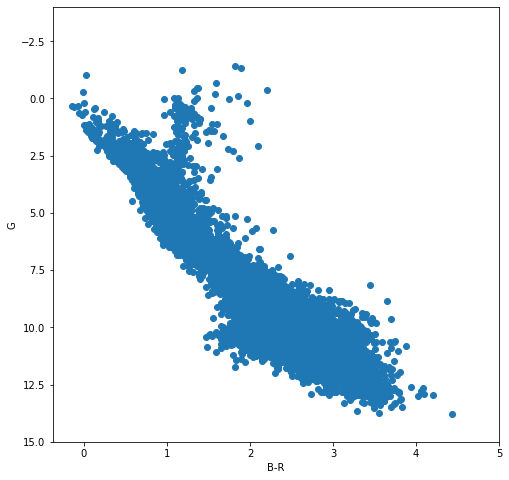

In [11]:
fig=plt.figure(figsize=(8,8))
plt.scatter(results["bp_rp"],results["mg"])
#plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlim(None,5)
plt.ylim(15,-4)
plt.xlabel("B-R")
plt.ylabel("G")

Text(0, 0.5, 'G')

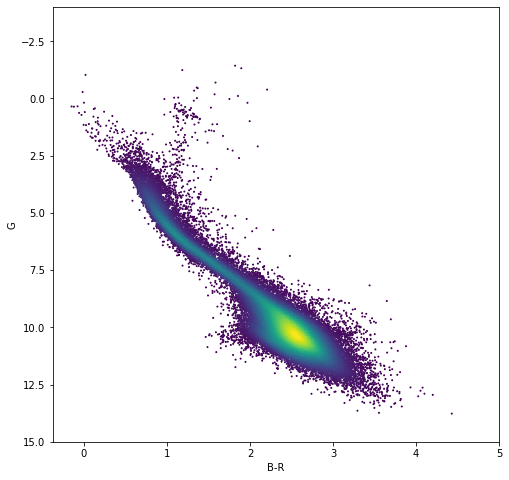

In [12]:
BMG = np.vstack([results["bp_rp"],results["mg"]])
dens = gaussian_kde(BMG)(BMG)

fig=plt.figure(figsize=(8,8))
plt.scatter(results["bp_rp"],results["mg"],s=1,c=dens)
plt.gca().invert_yaxis()
plt.xlim(None,5)
plt.ylim(15,-4)
plt.xlabel("B-R")
plt.ylabel("G")

Text(0, 0.5, 'Distance from GAIA')

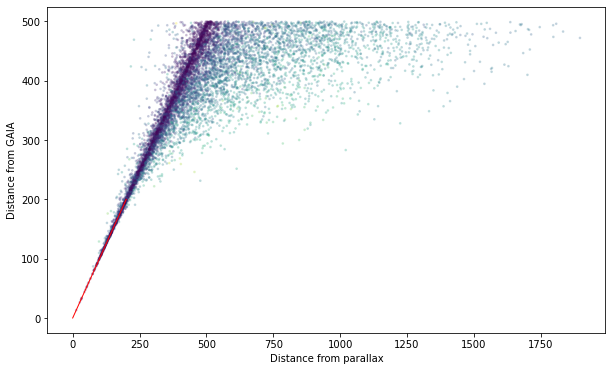

In [21]:
fig=plt.figure(figsize=(10,6))
plt.scatter(results["distance_parallax"],results["distance_gspphot"],c=results["parallax_error"],edgecolors=None,s=3,alpha=0.2)
xx=np.linspace(0,200)
plt.plot(xx,xx,color="red",linewidth=1)
plt.xlabel('Distance from parallax')
plt.ylabel("Distance from GAIA")

(array([   6.,    7.,   12.,   50.,   90.,  136.,  165.,  216.,  294.,
         339.,  376.,  430.,  517.,  587.,  679.,  789.,  820.,  928.,
        1028., 1077.]),
 array([ 13.206   ,  37.545155,  61.88431 ,  86.223465, 110.56262 ,
        134.90178 , 159.24094 , 183.5801  , 207.91924 , 232.25839 ,
        256.59756 , 280.9367  , 305.27585 , 329.61502 , 353.95416 ,
        378.29333 , 402.63248 , 426.97165 , 451.3108  , 475.64996 ,
        499.9891  ], dtype=float32),
 [<matplotlib.patches.Polygon at 0x17fa94460>])

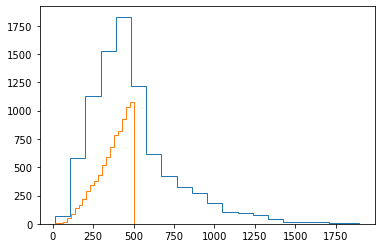

In [22]:
plt.hist(results["distance_parallax"],histtype="step",bins=20)
plt.hist(results["distance_gspphot"],histtype="step",bins=20)

## Comment: Distance from parallaxes

Parallax is the most accurate method of measuring the distances to stars. If we observe the same star at different times of the year, we can determine the it's distance based on how much it moves on the sky. A parsec (`u.pc`) is defined as the distance a star must have in order it's parallax is 1 arcsecond (`u.arcsec`). For a star with parallax ($\varpi$) it's distance is $  r = \frac{1}{\varpi}$.

GAIA provides us with precise astrometric measurements of star's parallax. However, even the small uncertainties of our measurements can create a bias in the distance estimations.

For -much- more details see Bailer-Jones 2015 and Bailer-Jones+ 2020


### How we can estimate the Distance to the star?
#### Likelihood
If the star has a true distance $r$ (so a true parallax of $1/r$) then the probabillity of observing the value $\varpi$ is
$$L\left(\varpi \mid r, \sigma_{\varpi}\right)=\frac{1}{\sqrt{2 \pi} \sigma_{\varpi}} \exp \left[-\frac{1}{2 \sigma_{\varpi}^2}\left(\varpi-\frac{1}{r}\right)^2\right]$$ 
where $\sigma_{\varpi}$ is the noise of our measurement assuming a normal distribution. 

0.0125 arcsec parallax


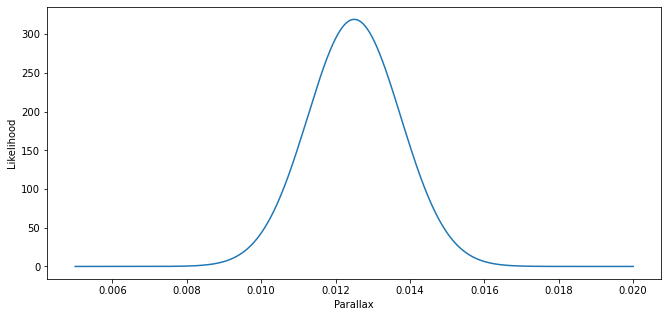

In [377]:
def likelihood(r, parallax, sigma_parallax):
    return 1.0/np.sqrt(2.0*np.pi*sigma_parallax**2) * np.exp( - (1.0/r-parallax)**2/(2.0*sigma_parallax**2) )
    
r_true=80.0 #Distance to the star in pc
p_true=1/r_true #Parallax in arcsec
print(f"{p_true} arcsec parallax")
sigma_p=0.1*p_true #10% percent error in parallax measurement
pp=np.linspace(0.005, 0.02, 1000)
fig = plt.figure(figsize=(11,5))
plt.plot(pp, likelihood(r_true,pp,sigma_p), label='Likelihood')
plt.xlabel("Parallax");
plt.ylabel("Likelihood");


#### Maximum Likelihood Method
Let's say we have measured the parallax of the star mentioned with a value of $\varpi = 0.013 \,\mathrm{arcsec}$ (instead of the real 0.0125). What is the estimated distance based on this?
This can be done using the maximum likelihood approach: We want the answer the question "what is the value of the parameter $r$ that maximises our likelihood for the given observable $\varpi$"

For numerical purposes is easier to calculate the log likelihood 
$$\log L \propto -\frac{1}{2 \sigma_{\varpi}^2} \left(\varpi-\frac{1}{r}\right)^2 $$
which maximizes at the value of $r=1/\varpi =76.9 \,\mathrm{pc}$ we have expected.

#### Multiple Observations
The method is easier to follow in the case we have a set of observations, $\bar{\varpi}$. The maximum likelihood approach is the answer to the question "what is the value of the parameter $r$ that maximises our likelihood of observing all the given observables $\bar{\varpi}$?"
If we assume that the observations are independed and the error is the same then the likelihood is
$$
\mathcal L=\prod_i L\left(\varpi_i \mid r, \sigma_{\varpi} \right)
$$
or
$$
\log \mathcal L=\sum_i \log L\left(\varpi_i \mid r, \sigma_{\varpi} \right) = -\frac{1}{2 \sigma_{\varpi}^2} \sum _i \left(\varpi _i-\frac{1}{r}\right)^2 +\mathrm{const}
$$

In the cell bellow you can play by changing the **number of observations** and the **error of the measurements** and see how the final Likelihood distribution changes.

/var/folders/l6/g1b2w7y10rg8qzc142j02b240000gn/T/ipykernel_2858/2455822177.py:12: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  def neg_logL(r,pp,sigma): return -np.sum(logLikelihood(r,p,sigma) for p in pp)


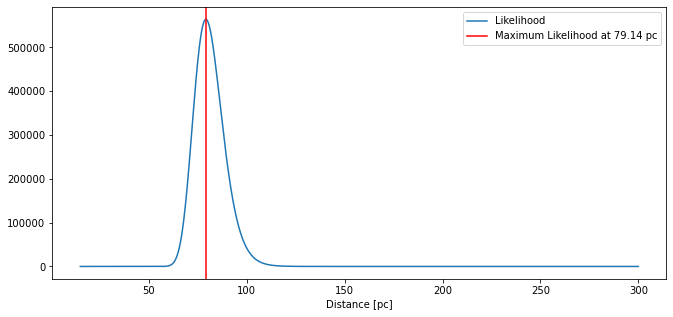

In [379]:
N=3 #Number of observations
sigma=0.002
r_true=80
p_true=1/r_true
p_dist = np.random.normal(p_true,sigma,N) # Parallax measurements

def Likelihood(r,p,sigma):
    return 1.0/np.sqrt(2.0*np.pi*sigma**2) * np.exp( - (1.0/r-p)**2/(2.0*sigma**2) )
def logLikelihood(r,p,sigma):
    return -0.5*(np.log(2.0*np.pi*sigma**2) + (1.0/r-p)**2/sigma**2 )

def neg_logL(r,pp,sigma): return -np.sum(logLikelihood(r,p,sigma) for p in pp)
# Run a minimizer in order to find the maximum. 
# Of course in the case of just one observation the best_r is just the 1/p_dist
res = minimize(neg_logL, [70.0], args=(p_dist,sigma), method='Nelder-Mead', tol=1e-5)
best_r=res.x[0]
best_r

rr=np.linspace(15.0, 300, 1000)
fig = plt.figure(figsize=(11,5))
plt.plot(rr, np.prod([Likelihood(rr,p,sigma) for p in p_dist],axis=0), label='Likelihood')
plt.xlabel("Distance [pc]")
plt.axvline(best_r,color="red",label=f"Maximum Likelihood at {best_r:.2f} pc")
plt.legend()

One can also note that the likelihood distribution is asymetric. This means that our distance estimation uncertainty is not symetrical.

Following this toy model we can simulate a population of stars randomly distributed in a sphere around our solar system. 
## Constant Volume density distributed stars

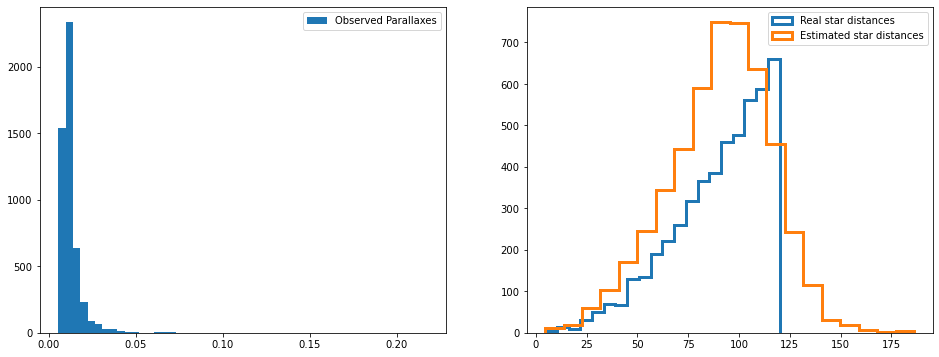

In [388]:
N_stars = 5000
dist_max = 120.0

# Generate random distances within nearest 100 pc
distance = dist_max*np.random.rand(N_stars)**(1.0/3.0)

# Take one observation per star
plx = 1.0/distance #parallax
plx_err = 1e-3 * np.ones(len(plx))
#then create simulated measurement
plx_obs = np.random.normal(plx, plx_err, size=N_stars)

fig,ax=plt.subplots(1,2,figsize=(16,6))
ax[0].hist(plx_obs, bins=50,label="Observed Parallaxes");

est_dist_like=[]
for i in range(N_stars):
    #res = minimize(neg_logL, [1/plx_obs[i]], args=([plx_obs[i]], plx_err[i]), method='Nelder-Mead', tol=1e-5)
    #best_r=res.x[0]
    # Because we take only one measurement per star we don't have to use an optimizer to find the maximum
    # You can modify the above data in order to simulate the case of multiple observations
    est_dist_like.append(1/plx_obs[i])
ax[1].hist(distance, bins=20, density=False,histtype="step",label="Real star distances",linewidth=3);
ax[1].hist(est_dist_like, bins=20, density=False,histtype="step",label="Estimated star distances",linewidth=3);
ax[0].legend()
ax[1].legend()

In the above result we see the same difference we have witnessed on our GAIA data. Next we will use the Bayes rule in order to correct our distances estimation. 

### Bayesian statistics
#### Posterior distribution
Using the bayes rule we can estimate directly the distance **distribution** to a star. This distribution is called the posterior distribution which interprets to "the distribution of our parameter $r$ based on a set of observations $\varpi$" or
$$
P\left(r \mid \varpi, \sigma_{\varpi}\right)=\frac{1}{Z} L\left(\varpi \mid r, \sigma_{\varpi}\right) P(r)
$$
where $P(r)$ is the prior distribution regarding the parameter and $Z$ is a normalization constant
$$
Z=\int_{r=0}^{r=\infty} L\left(\varpi \mid r, \sigma_{\varpi}\right) P(r) d r
$$

Based on this we understand that our previous estimations (based on the Maximum Likelihood) are exactly the same under the assumption that $P(r)$ is a uniform distribution (any distance is possible). 

#### Prior distribution
A uniform distribution is not always uninformative. In the case of a uniform distribution of distances from a point source (our solar system) in a 3d universe means that the volume density of stars is $\propto 1/r^2$ which is highly unrealistic and highly informative. 

Adopting a more realistic scenario of a uniform volume density of stars 
$$
P(r) = 3\frac{r^2}{r_\mathrm{max}^3}
$$

In [160]:
def prior(r, r_max):
    if r<0:
        return 0.0
    elif r>r_max:
        return 0.0
    else:
        return 3.0 * r**2 / r_max**3  
        
def logprior(r, r_max):
    if r<0:
        return -np.inf
    elif r>r_max:
        return -np.inf
    else:
        return np.log(3.0 * r**2 / r_max**3  )

def posterior(r, parallax, sigma_parallax, r_max):
    return prior(r, r_max) * np.prod(Likelihood(r, parallax, sigma_parallax))

def neg_log_posterior(r, parallax, sigma_parallax, r_max): 
    return -logprior(r, r_max) -np.sum(logLikelihood(r, parallax, sigma_parallax))

Using the same techniques as in the previous chapter we estimate now the maximum of the posterior distribution (MPE).
- Notice that the distributions plotted bellow are normalized.

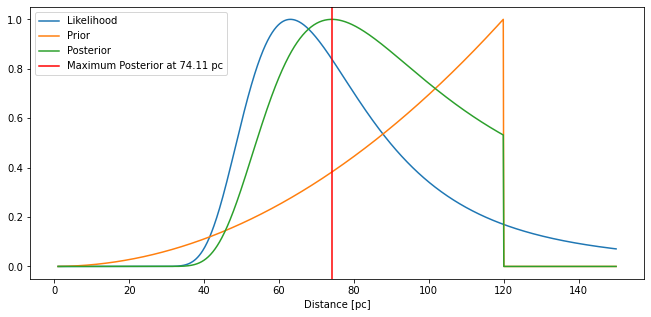

In [385]:
rmax=120.0
N=1 #Number of observations
sigma=0.004
p_true=1/70
p_dist = np.random.normal(p_true,sigma,N) # Parallax measurements

res = minimize(neg_log_posterior, [50.0], args=(p_dist, sigma,rmax), method='Nelder-Mead')
best_r=res.x[0]

rr=np.linspace(1.0, 150, 1000)
like=np.prod([Likelihood(rr,p,sigma) for p in p_dist],axis=0) #[Likelihood(r,p_dist,sigma) for r in rr]
Prior=[prior(r, rmax) for r in rr]
Posterior=[posterior(r,p_dist,sigma,rmax) for r in rr] #[posterior(rr,p_dist,sigma,rmax) for r in rr]

fig =plt.figure(figsize=(11,5))
plt.plot(rr, np.array(like)/np.max(like), label='Likelihood')
plt.plot(rr, Prior/np.max(Prior), label='Prior')
plt.plot(rr, Posterior/np.max(Posterior), label='Posterior')

plt.xlabel("Distance [pc]")
plt.axvline(best_r,color="red",label=f"Maximum Posterior at {best_r:.2f} pc")
plt.legend()

And use the same analysis for the stars population

/var/folders/l6/g1b2w7y10rg8qzc142j02b240000gn/T/ipykernel_2858/3443055696.py:15: RuntimeWarning: divide by zero encountered in log
  return np.log(3.0 * r**2 / r_max**3  )
/var/folders/l6/g1b2w7y10rg8qzc142j02b240000gn/T/ipykernel_2858/2455822177.py:10: RuntimeWarning: divide by zero encountered in true_divide
  return -0.5*(np.log(2.0*np.pi*sigma**2) + (1.0/r-p)**2/sigma**2 )


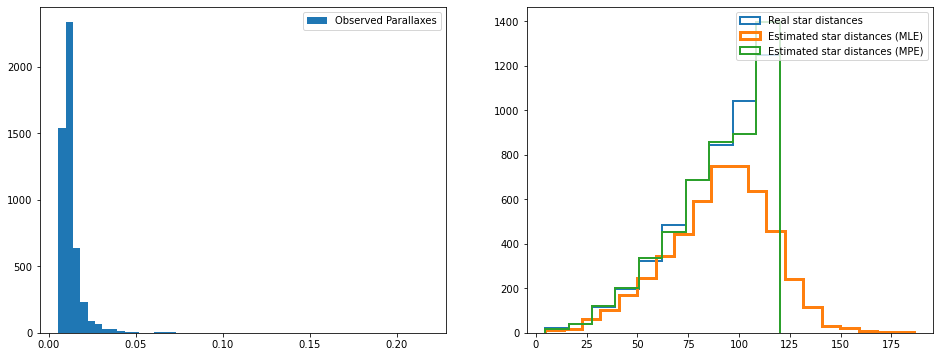

In [389]:
dist_max = 120.0

fig,ax=plt.subplots(1,2,figsize=(16,6))
ax[0].hist(plx_obs, bins=50,label="Observed Parallaxes");

est_dist_post=[]
for i in range(N_stars):
    res = minimize(neg_log_posterior, [40.0], args=(plx_obs[i], plx_err[i],dist_max), method='Nelder-Mead', tol=1e-5)
    est_dist_post.append(res.x[0])
ax[1].hist(distance, bins=10, density=False,histtype="step",label="Real star distances",linewidth=2);
ax[1].hist(est_dist_like, bins=20, density=False,histtype="step",label="Estimated star distances (MLE)",linewidth=3);
ax[1].hist(est_dist_post, bins=10, density=False,histtype="step",label="Estimated star distances (MPE)",linewidth=2);
ax[0].legend()
ax[1].legend()

In [ ]:
msk=(results["distance_gspphot"]<=dist_max) & (~np.isnan(results["parallax_error"]))& (results["parallax"]>0.0)& (results["parallax_error"]>0.0)

/var/folders/l6/g1b2w7y10rg8qzc142j02b240000gn/T/ipykernel_2858/3443055696.py:15: RuntimeWarning: divide by zero encountered in log
  return np.log(3.0 * r**2 / r_max**3  )
/var/folders/l6/g1b2w7y10rg8qzc142j02b240000gn/T/ipykernel_2858/2455822177.py:10: RuntimeWarning: divide by zero encountered in true_divide
  return -0.5*(np.log(2.0*np.pi*sigma**2) + (1.0/r-p)**2/sigma**2 )


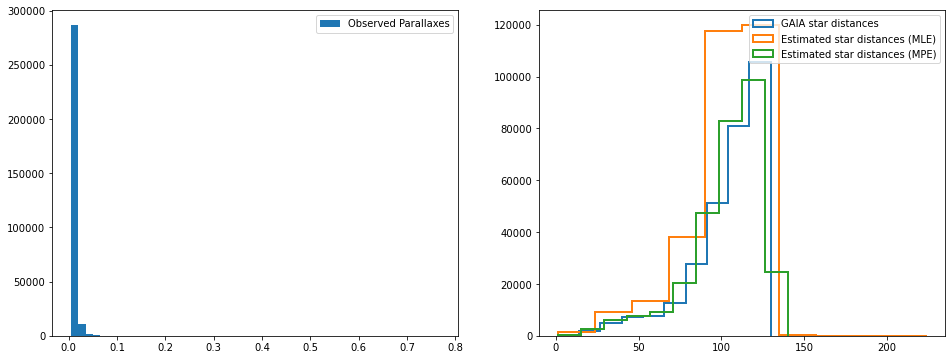

In [398]:
plx_obs = results["parallax"].to(u.arcsec).value
plx_err = results["parallax_error"].to(u.arcsec).value
gaia_distance=results["distance_gspphot"].to(u.pc).value
fig,ax=plt.subplots(1,2,figsize=(16,6))
ax[0].hist(plx_obs, bins=50,label="Observed Parallaxes");

est_dist=[]
dist_max=140
for i in range(len(plx_obs)):
    res = minimize(neg_log_posterior, [40.0], args=(plx_obs[i], plx_err[i],dist_max), method='Nelder-Mead', tol=5e-3)
    est_dist.append(res.x[0])
ax[1].hist(gaia_distance, bins=10, density=False,histtype="step",label="GAIA star distances",linewidth=2);
ax[1].hist(1/plx_obs, bins=10, density=False,histtype="step",label="Estimated star distances (MLE)",linewidth=2);
ax[1].hist(est_dist, bins=10, density=False,histtype="step",label="Estimated star distances (MPE)",linewidth=2);
ax[0].legend()
ax[1].legend()

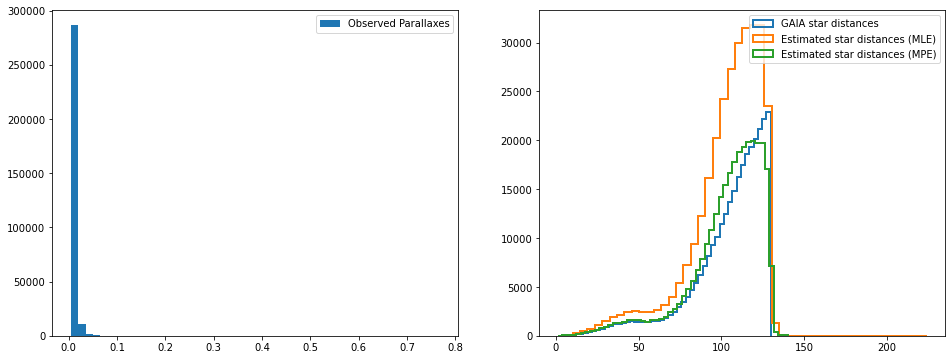

In [399]:
fig,ax=plt.subplots(1,2,figsize=(16,6))
ax[0].hist(plx_obs, bins=50,label="Observed Parallaxes");
ax[1].hist(gaia_distance, bins=50, density=False,histtype="step",label="GAIA star distances",linewidth=2);
ax[1].hist(results["distance_parallax"], bins=50, density=False,histtype="step",label="Estimated star distances (MLE)",linewidth=2);
ax[1].hist(est_dist, bins=50, density=False,histtype="step",label="Estimated star distances (MPE)",linewidth=2);
ax[0].legend()
ax[1].legend()

### Selecting further away stars

In [407]:
query_far = """SELECT TOP 5000 parallax,parallax_error, distance_gspphot, 1000/ABS(parallax) AS distance_parallax
FROM gaiadr3.gaia_source 
WHERE (distance_gspphot < 6000) AND (distance_gspphot > 100)
AND parallax_over_error > 3.0
AND ruwe < 1.4
"""
job_far     = Gaia.launch_job_async(query_far)
results_far = job_far.get_results()
print(f'Table size (rows): {len(results_far)}')
results_far

INFO: Query finished. [astroquery.utils.tap.core]
Table size (rows): 5000


parallax,parallax_error,distance_gspphot,distance_parallax
mas,mas,pc,
float64,float32,float32,float64
1.164497117867116,0.012428325,843.3253,858.7397810237542
0.31775896767504064,0.07318938,1263.4143,3147.039428396746
0.4792889777630783,0.046640232,1237.3989,2086.4239454601416
0.37664181141920905,0.07360376,1404.4136,2655.042455939609
0.391953887049996,0.08405018,1259.7485,2551.320532949439
0.8245354987377633,0.106992625,684.6721,1212.8040594138708
1.2278074301594974,0.12681232,720.1059,814.4599677736888
0.8838350337625095,0.119975284,774.4294,1131.4328599795067


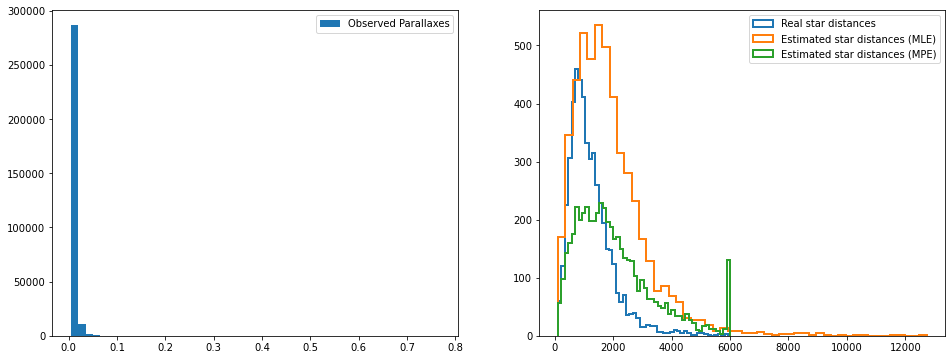

In [409]:
plx_obs_far = results_far["parallax"].to(u.arcsec).value
plx_err_far = results_far["parallax_error"].to(u.arcsec).value
distance_far=results_far["distance_gspphot"].to(u.pc).value
fig,ax=plt.subplots(1,2,figsize=(16,6))
ax[0].hist(plx_obs, bins=50,label="Observed Parallaxes");
est_dist_far=[]
for i in range(len(plx_obs_far)):
    res_far = minimize(neg_log_posterior, [40.0], args=(plx_obs_far[i], plx_err_far[i],6000), method='Nelder-Mead', tol=1e-3)
    est_dist_far.append(res_far.x[0])
ax[1].hist(distance_far, bins=50, density=False,histtype="step",label="Real star distances",linewidth=2);
ax[1].hist(results_far["distance_parallax"], bins=50, density=False,histtype="step",label="Estimated star distances (MLE)",linewidth=2);
ax[1].hist(est_dist_far, bins=50, density=False,histtype="step",label="Estimated star distances (MPE)",linewidth=2);
ax[0].legend()
ax[1].legend()